## Tutorial for Classification Machine Learning and Statistical Analysis on Simulations of PTP1B. 

In this jupyter notebook we will use the model_building.py and stat_modelling.py modules to identify differences in the molecular interactions across PTP1B when the WPD-loop of PTP1B is in the Closed state, versus when the WPD-loop is in the Open state.

This notebook will also cover all the pre- and post-processing steps requireds to prepare, analyse and visualise the results.

The dataset used here is for WT PTP1B and is the same data as what was used in the manuscript. 

### Adapting this to use with LBP simulation data (conformational change)
* Instead of PTP1B closed to open, we can look at the closed to open transitions.

In [1]:
import pandas as pd

from key_interactions_finder import data_preperation
from key_interactions_finder import model_building
from key_interactions_finder import stat_modelling
from key_interactions_finder import post_proccessing
from key_interactions_finder import pymol_projections

/ihome/lchong/dty7/Apps/anaconda3/envs/kif/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ihome/lchong/dty7/Apps/anaconda3/envs/kif/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


At this point, we'll define the location of our downloaded input files and where we would like to save our output files to throughout this tutorial.

In [6]:
# save in current dir or alt
save_dir = ""

# Where all input data is stored. 
#in_dir = save_dir + r"data/"
in_dir = save_dir

# The target variable's per frame values are stored here. 
classifications_file = in_dir + r"class_assignments_withneither_10i.txt"

# The pdb file will later be used to determine the distance of each residue to a site of interest.
# Original crystall structure state (major conformation)
pdb_file = in_dir + r"1lst_dry.pdb"

# output folders for the stats and ml analysis. These will be created if they don't already exist.
stats_out_dir = save_dir + r"LBP_stat_analysis"
ml_out_dir = save_dir + r"LBP_ml_analysis"

### Preparation Step 1: Load the non-covalent interaction datasets

The contact identification calculation was split into 4 blocks of different residues ranges. We will first need to load these blocks in and merge them. Luckly this is very easy with pandas. 

Note this data was generated using the script: "identify_contacts.py" which is provided with KIF.

In [48]:
#input_files = ["PTP1B_block1.csv", "PTP1B_block2.csv", "PTP1B_block3.csv", "PTP1B_block4.csv"]
#input_files = ["contacts_all_res.csv"]
#input_files = ["contacts_all_10i.csv"]
input_files = ["contacts_merged_10i.csv"]
dfs = []
for file_name in input_files:
    file_path = in_dir + file_name
    df = pd.read_csv(file_path)
    dfs.append(df)

all_contacts_df = pd.concat(dfs, join='outer', axis=1)
all_contacts_df.head(3)

,3Pro 6Val Hydrophobic,2Leu 41Met Other,2Leu 43Val Hydrophobic,3Pro 43Val Hydrophobic,3Pro 65Asp Other,4Gln 42Gln Hbond,4Gln 43Val Other,4Gln 44Lys Hbond,5Thr 43Val Other,5Thr 44Lys Hbond,...,226Met 229Lys Hbond,226Met 230Tyr Other,227Ala 230Tyr Other,227Ala 231Phe Hydrophobic,227Ala 235Val Hydrophobic,228Lys 231Phe Hbond,228Lys 232Asp Saltbr,231Phe 235Val Hydrophobic,234Asn 237Gly Hbond,234Asn 238Asp Hbond
0,0.5329,0.3142,0.2983,1.7172,0.0003,0.9915,4.2693,10.8300,0.0026,3.6985,...,2.1654,2.5094,4.4450,8.2710,1.0146,4.8463,0.0174,4.6154,1.3497,0.0001
1,0.5528,0.2583,0.0727,2.0700,0.0002,0.0172,3.4245,5.3518,0.0174,4.8669,...,4.1190,3.9452,3.3073,6.3502,0.5429,4.9758,0.2229,4.4195,1.2363,0.0001
2,0.1342,0.0135,0.0062,0.9421,0.0000,0.0011,2.7918,4.0636,0.0243,7.3735,...,5.1370,3.2289,4.1669,5.8355,0.8972,3.4915,0.0256,2.4443,0.8852,0.0000


We can see we now have a dataframe with all the contacts found (989) identified and of length 10000, with matches with the number of frames in the trajectory. 

In [49]:
all_contacts_df.shape

(20000, 682)

### Preparation Step 2. Prepare the Dataset for calculations with the data_preperation.py module. 

In this step, we take our dataframe and merge our per frame classifications file to it.

We can also optionally perform several forms of filtering on the non-covalent interactions identified to select what types of interactions we would like to study.  

In [50]:
# First we generate an instance of the SupervisedFeatureData class (because we have per frame target labels).
supervised_dataset = data_preperation.SupervisedFeatureData(
    input_df=all_contacts_df,
    target_file=classifications_file,
    is_classification=True,
    header_present=False # If your target_file has a header present, set to True.
)

Your PyContact features and target variable have been succesufully merged.
You can access this dataset through the class attribute: '.df_processed'.


In [51]:
# As stated above to access the newly generated dataframe we can use the class attribute as follows
supervised_dataset.df_processed

,Target,3Pro 6Val Hydrophobic,2Leu 41Met Other,2Leu 43Val Hydrophobic,3Pro 43Val Hydrophobic,3Pro 65Asp Other,4Gln 42Gln Hbond,4Gln 43Val Other,4Gln 44Lys Hbond,5Thr 43Val Other,...,226Met 229Lys Hbond,226Met 230Tyr Other,227Ala 230Tyr Other,227Ala 231Phe Hydrophobic,227Ala 235Val Hydrophobic,228Lys 231Phe Hbond,228Lys 232Asp Saltbr,231Phe 235Val Hydrophobic,234Asn 237Gly Hbond,234Asn 238Asp Hbond
0,open,0.5329,0.3142,0.2983,1.7172,0.0003,0.9915,4.2693,10.8300,0.0026,...,2.1654,2.5094,4.4450,8.2710,1.0146,4.8463,0.0174,4.6154,1.3497,0.0001
1,open,0.5528,0.2583,0.0727,2.0700,0.0002,0.0172,3.4245,5.3518,0.0174,...,4.1190,3.9452,3.3073,6.3502,0.5429,4.9758,0.2229,4.4195,1.2363,0.0001
2,open,0.1342,0.0135,0.0062,0.9421,0.0000,0.0011,2.7918,4.0636,0.0243,...,5.1370,3.2289,4.1669,5.8355,0.8972,3.4915,0.0256,2.4443,0.8852,0.0000
3,open,1.3588,1.2146,0.9647,2.8848,0.0107,0.0415,3.1210,6.1990,0.0108,...,2.6176,2.1097,4.2430,7.0550,0.3698,6.8199,2.8362,2.9558,1.7422,0.0001
4,open,5.9673,2.2893,1.5990,0.7918,0.8938,0.0028,2.8498,9.1154,0.0031,...,4.9873,1.2366,4.1340,6.3315,0.4919,4.1251,0.0650,3.1777,1.0016,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,closed,0.4880,0.2359,0.1829,2.6393,0.0007,0.0012,1.0653,6.7574,0.0961,...,6.0054,3.9118,1.9167,6.4007,0.7681,3.4088,0.0019,1.5845,3.3009,1.5278
19996,closed,1.0091,0.1129,1.1574,2.2330,0.0330,0.0028,1.7307,3.6708,0.0255,...,3.1211,2.4759,4.1000,6.4734,0.9019,3.4712,0.0006,2.9561,5.6275,0.0710
19997,closed,0.1184,0.1450,0.7409,1.1615,0.0001,0.0001,0.3604,3.6894,0.0345,...,4.0278,4.9154,4.2875,5.8551,0.4131,6.5720,0.0188,3.9111,9.7388,4.4154
19998,closed,0.0773,0.2530,0.8547,1.0210,0.0000,0.0074,1.8511,3.1967,0.1885,...,3.0864,2.9089,2.1531,5.3433,0.6042,3.3352,0.0230,4.5739,5.8783,5.2084


##### Optional Feature Filtering

In the above dataframe we have n columns. We can take all of these forward for the statistical analysis or we can perform some filtering in advance (the choice is yours). 
There are five built in filtering methods available to you to perform filtering:

1. **filter_by_occupancy(min_occupancy)** - Remove features that have an %occupancy less than the provided cut-off. %Occupancy is the % of frames with a non 0 value, i.e. the interaction is present in that frame.

2. **filter_by_interaction_type(interaction_types_included)** - Inteactions are defined as one of four possible types: ("Hbond", "Saltbr", "Hydrophobic", "Other"). You select the interactions you want to include.

3. **filter_by_avg_strength(average_strength_cut_off)** - Filter by the per frame contact score/strength for each interaction. You can filter features by the average score. Values below the cut-off are removed. 

4. **filter_by_occupancy_by_class(min_occupancy)** - Special alternative to the the standard filter features by occupancy method. %occupancy is determined for each class (as opposed to whole dataset), meaning only observations from 1 class have to meet the cut-off to keep the feature. Only avaible to datasets with a categorical target variable (classification). 


Finally if at any point in time you want to reset any filtering you've already performed, you can use the following method: 

5. **reset_filtering()** 


In [52]:
# An example of filtering the dataset using the available methods. 
supervised_dataset.reset_filtering() 
print(f"Number of features before any filtering: {len(supervised_dataset.df_processed.columns) - 1}")

# Features with a %occupancy of less than 25% are removed. 
supervised_dataset.filter_by_occupancy_by_class(min_occupancy=25)
print(f"Number of features after filtering by occupancy: {len(supervised_dataset.df_filtered.columns) - 1}")

# Remove features with interaction type "Other". 
supervised_dataset.filter_by_interaction_type(
    interaction_types_included=["Hbond", "Saltbr", "Hydrophobic"]) 
print(f"Number of features after filtering by interaction type: {len(supervised_dataset.df_filtered.columns) - 1}")

# Features with an average interaction strength less than 0.5 will be removed. 
supervised_dataset.filter_by_avg_strength(
    average_strength_cut_off=0.5,  
)
print(f"Number of features after filtering by average interaction scores: {len(supervised_dataset.df_filtered.columns) - 1}")

Number of features before any filtering: 682
Number of features after filtering by occupancy: 681
Number of features after filtering by interaction type: 378
Number of features after filtering by average interaction scores: 334


Now if we look at the class attributes of our SupervisedFeatureData() instance (we called it: supervised_dataset) using the special "\_\_dict__" method we can see two dataframes we could use in the statistical analysis to follow. 

In [53]:
supervised_dataset.__dict__.keys()

dict_keys(['input_df', 'is_classification', 'target_file', 'header_present', 'df_processed', 'df_filtered'])

They are: 
- 'df_processed' - The unfiltered dataframe
- 'df_filtered' - The filtered dataframe

In the following sections we will use the filtered dataframe but either dataframe could be justified based on your goals. 

In [54]:
supervised_dataset.df_filtered

,Target,98Lys 178Tyr Hbond,98Lys 177Glu Saltbr,98Lys 176Lys Hbond,97Ala 150Leu Hydrophobic,97Ala 100Ser Hbond,96Ala 181Ala Hydrophobic,96Ala 179Ala Hydrophobic,96Ala 102Ile Hydrophobic,95Ile 180Phe Hydrophobic,...,105Thr 108Ser Hbond,104Pro 183Pro Hydrophobic,104Pro 181Ala Hydrophobic,104Pro 130Trp Hbond,104Pro 109Leu Hydrophobic,103Gln 181Ala Hbond,103Gln 108Ser Hbond,102Ile 181Ala Hydrophobic,102Ile 109Leu Hydrophobic,100Ser 156Asp Hbond
0,open,2.2196,6.6927,2.9951,0.0004,5.3226,0.2566,5.8188,0.6773,2.2829,...,4.8184,1.0332,2.7846,0.0048,0.1555,0.2941,5.4690,1.0816,0.2628,0.0002
1,open,3.4723,5.4602,1.6337,0.0009,5.2617,0.8459,7.7100,0.4893,1.2165,...,6.6230,1.4998,2.1896,1.7524,0.0323,0.0495,5.9963,1.8600,0.8436,0.0003
2,open,5.5151,5.9816,3.4247,0.0002,3.0168,0.8234,7.2058,2.4520,2.4205,...,5.2565,1.0581,4.1095,0.7932,1.9413,0.3060,5.9519,1.2689,0.0745,0.0001
3,open,4.0564,7.7428,1.3108,0.0006,3.2617,0.2080,7.4634,0.0106,1.8717,...,5.3120,0.8045,2.5094,3.0193,0.3131,0.3684,7.3297,1.0753,1.0128,0.0000
4,open,2.0435,7.8003,0.0065,0.0002,2.7963,0.4199,6.8458,0.0094,2.9681,...,3.4638,0.0048,0.8998,1.7571,0.0786,0.0083,4.2944,1.2352,0.7117,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,closed,0.0023,3.1732,0.0000,1.8152,0.4719,0.5818,8.1799,0.1490,2.0036,...,4.8733,1.4102,3.2694,4.6895,0.9302,1.8504,4.8606,3.7057,0.3970,0.0018
19996,closed,0.0066,7.6948,0.0000,0.3681,3.1753,0.4313,3.6710,0.0375,2.1168,...,3.7049,1.7590,3.5458,0.2265,0.5534,0.1001,5.5715,1.0861,1.0581,0.0019
19997,closed,0.0183,9.2752,0.0000,0.4273,0.1219,1.5541,5.1516,0.0410,5.1020,...,5.9729,3.9002,2.2463,0.6757,0.3026,1.2901,5.4080,3.1844,0.2420,0.0274
19998,closed,0.0021,5.7598,0.0000,0.6639,1.2664,1.8053,5.7275,0.3167,2.8219,...,5.2653,0.4635,1.1681,0.1201,0.3305,0.3161,5.2517,4.0943,0.0853,0.0031


In [55]:
supervised_dataset.df_filtered.isnull().values.any()

np.False_

In [56]:
supervised_dataset.df_filtered.shape

(20000, 335)

In [23]:
supervised_dataset.df_filtered.dropna(axis=1)

,Target,9Gly 69Ser Hbond,9Gly 50Ser Hbond,98Lys 178Tyr Hbond,98Lys 177Glu Saltbr,98Lys 176Lys Hbond,97Ala 155Leu Hydrophobic,97Ala 150Leu Hydrophobic,97Ala 100Ser Hbond,96Ala 181Ala Hydrophobic,...,104Pro 181Ala Hydrophobic,104Pro 130Trp Hbond,104Pro 109Leu Hydrophobic,103Gln 181Ala Hbond,103Gln 108Ser Hbond,102Ile 181Ala Hydrophobic,102Ile 109Leu Hydrophobic,101Pro 181Ala Hydrophobic,101Pro 108Ser Hbond,100Ser 112Lys Hbond
0,open,0.1501,1.1166,2.2196,6.6927,2.9951,0.0000,0.0004,5.3226,0.2566,...,2.7846,0.0048,0.1555,0.2941,5.4690,1.0816,0.2628,0.0000,1.1458,0.0000
1,open,0.0154,2.5704,3.4723,5.4602,1.6337,0.0000,0.0009,5.2617,0.8459,...,2.1896,1.7524,0.0323,0.0495,5.9963,1.8600,0.8436,0.0000,0.8567,0.0000
2,open,0.0175,0.5351,5.5151,5.9816,3.4247,0.0002,0.0002,3.0168,0.8234,...,4.1095,0.7932,1.9413,0.3060,5.9519,1.2689,0.0745,0.0000,1.0575,0.8949
3,open,0.0176,1.6425,4.0564,7.7428,1.3108,0.0000,0.0006,3.2617,0.2080,...,2.5094,3.0193,0.3131,0.3684,7.3297,1.0753,1.0128,0.0000,0.0336,0.0000
4,open,0.1046,0.6542,2.0435,7.8003,0.0065,0.0000,0.0002,2.7963,0.4199,...,0.8998,1.7571,0.0786,0.0083,4.2944,1.2352,0.7117,0.0000,0.0107,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,closed,3.5565,0.0083,6.2767,3.1251,9.2131,2.2660,3.7325,7.0304,4.8733,...,1.3207,3.8751,8.2662,0.3503,5.3229,0.4944,2.3400,1.5735,3.1447,6.2437
19996,closed,3.2376,0.0049,6.9223,0.9784,13.0024,1.9252,6.2159,7.2790,3.7049,...,1.1520,2.8340,10.9411,0.8394,3.7553,1.5075,3.5444,0.2138,1.7076,3.9411
19997,closed,3.2663,0.0009,8.4582,1.3587,7.8868,2.9809,7.0876,6.7292,5.9729,...,0.2944,1.6534,7.3688,0.1596,5.9558,2.0222,0.2322,0.0003,1.0424,3.2056
19998,closed,3.1762,0.0577,6.1486,1.4210,11.0404,3.2518,4.1630,6.3636,5.2653,...,1.8807,3.4687,10.9918,0.4895,4.0539,2.0900,2.1292,1.6673,2.7152,7.6738


Had to drop ~39 features since these had NaN values

In [25]:
supervised_dataset.df_filtered = supervised_dataset.df_filtered.dropna(axis=1)

In [57]:
supervised_dataset.df_filtered.shape

(20000, 335)

## Analysis Time! 

Our dataset is now ready for either statistical analysis or ML or both! 

### Part 1.1. Perform Statistical Analysis with the stat_modelling.py module. 

Now we will perform the actual statistical modelling to compare the differences for each feature between states.

With this module, we can calculate two different metrics to evaluate how different/similar each feature is when the protein is in the different conformations: 

1. The [Jensen-Shannon distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html). For this method, Kernel density estimations (KDEs) are calculated for the normalised interaction stength of feature in each state before performing the calculation. We can also extract these KDEs as we did in the manuscript (and will show you how to do it here) to compare the interaction strengths for each state. 

2. The [mutual information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) using the implementation available in Scikit-learn. The mutual information can capture any kind of dependancy/relationship between variables and score their dependancy

In both cases, the higher the score, the more "different" the feature is when in the two different states. Scores are in the range 0 and 1.   

In [59]:
stat_model = stat_modelling.ClassificationStatModel(
    dataset=supervised_dataset.df_filtered, 
    class_names=["closed", "open"], # select the two class labels to compare. Has to be 2 labels. 
    out_dir=stats_out_dir,
    interaction_types_included=["Hbond", "Saltbr", "Hydrophobic"] # select which interaction types to include, in this case: "Other" removed. 
)

In [60]:
# First we can calculate the Jensen-Shannon distances
stat_model.calc_js_distances()

Jensen-Shannon (JS) distances calculated.
LBP_stat_analysis/Jensen_Shannon_Per_Feature_Scores.csv written to disk.
You can also access these results via the class attribute: 'js_distances'.


In [61]:
# Now we can calculate the mutual information
stat_model.calc_mutual_info_to_target()

Mutual information scores calculated.
LBP_stat_analysis/Mutual_Information_Per_Feature_Scores.csv written to disk.
You can also access these results via the class attribute: 'mutual_infos'.


In [62]:
# As printed above we can access the results from these calculations from the class instance's (we called it stat_model) attributes. 
mi_results = stat_model.mutual_infos
js_results = stat_model.js_distances
# stat_model.__dict__.keys() # uncomment to see all attributes available. 

### Part 1.2. Work up the Statistical Analysis with the post_proccessing.py module. 

In this module we have access to 3 methods to process the results. 

1. We can convert the per feature scores to per residue scores, by summing (and then normalising) every per feature score that each residue is involved in.
This can allow us to identify residues which seem to differ the most between each state. 

2. We can also try to predict the "direction" that each feature favours. This essentially means in which class is the feature on average stronger in.  

3. We can obtain the kernel density estimations for selected interactions to compare how the interactions stengths differ between states. 

In [63]:
# First generate an instance of the class. 
post_proc = post_proccessing.StatClassificationPostProcessor(
    stat_model=stat_model,
    out_dir=stats_out_dir
)

# As you have already seen in the prior steps, we can take a look at class attributes with the __dict__ method. 
# Note that some of these attributes will be empty until we have run the next few code blocks.
post_proc.__dict__.keys()

dict_keys(['stat_model', 'out_dir', 'per_residue_mutual_infos', 'per_residue_js_distances', 'feature_directions'])

In [64]:
# Now we can run the get_per_res_scores() method, changing the stat_method accordingly.
js_per_res_scores = post_proc.get_per_res_scores(
    stat_method="jensen_shannon")
mi_per_res_scores = post_proc.get_per_res_scores(
    stat_method="mutual_information")

LBP_stat_analysis/Jensen_Shannon_Distance_Scores_Per_Residue.csv written to disk.
LBP_stat_analysis/Mutual_Information_Scores_Per_Residue.csv written to disk.


In [65]:
# Here we predict the "direction" that each feature favours. 
# This essentially means in which class is the feature on average stronger in.  
# Because of the nature of the method, a warning is given. 
post_proc.estimate_feature_directions()

LBP_stat_analysis/Feature_Direction_Estimates.csv written to disk.
You can access these predictions through the 'feature_directions' class attribute.


/ihome/lchong/dty7/Apps/anaconda3/envs/kif/lib/python3.11/site-packages/key_interactions_finder/post_proccessing.py:774: UserWarning:

Warning, this method is very simplistic and just calculates the average contact score/strength for all features for both classes to determine the direction each feature appears to favour. You should therefore interpret these results with care...



In [66]:
# We can also extract the kernel density estimations for the feature with the largest differences. 
x_values, selected_kdes = post_proc.get_kdes(
    number_features=10) # top 10 features based on Jensen Shannon Distances. 

selected_kdes["closed"].keys() # here we can see what features were in the top 10 and could be plotted. 

dict_keys(['14Tyr 161Asp Hbond', '77Arg 121Thr Hbond', '10Thr 68Ile Hbond', '72Ser 121Thr Hbond', '74Thr 121Thr Hbond', '14Tyr 143Gln Hbond', '75Asp 188Lys Saltbr', '17Phe 164Ala Hydrophobic', '91Asp 184Ser Hbond', '162Glu 184Ser Hbond'])

In [67]:
selected_kdes["open"].keys() 

dict_keys(['14Tyr 161Asp Hbond', '77Arg 121Thr Hbond', '10Thr 68Ile Hbond', '72Ser 121Thr Hbond', '74Thr 121Thr Hbond', '14Tyr 143Gln Hbond', '75Asp 188Lys Saltbr', '17Phe 164Ala Hydrophobic', '91Asp 184Ser Hbond', '162Glu 184Ser Hbond'])

**Optional:** Now we will take a look at the most different feature in both states using the plotly plotting library. 

In [68]:
import plotly.express as px
import plotly.graph_objects as go

In [70]:
interaction_df = pd.DataFrame(
    {"Normalised Interaction Strength": list(x_values[:, 0]),
     "Closed": selected_kdes["closed"]['14Tyr 161Asp Hbond'],
     "Open": selected_kdes["open"]['14Tyr 161Asp Hbond']
    }
)

interaction_df.head()

,Normalised Interaction Strength,Closed,Open
0,0.00,0.269569,18.388928
1,0.02,0.208417,11.694717
2,0.04,0.105272,3.124036
3,0.06,0.075119,0.668882
4,0.08,0.073774,0.336527


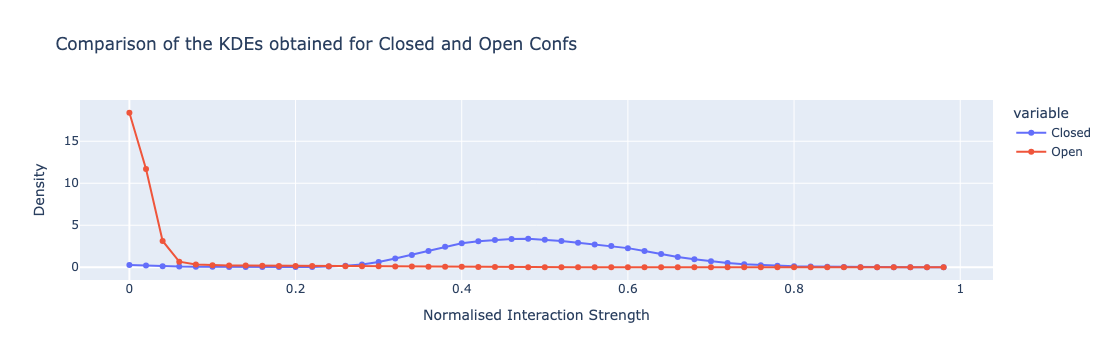

In [71]:
fig = px.line(interaction_df, x="Normalised Interaction Strength", y=["Closed", "Open"], 
    markers=True, title="Comparison of the KDEs obtained for Closed and Open Confs"
)
fig.update_layout(yaxis_title="Density")
fig.show() # to make this plot interactive, remove "svg" and run the cell block. 

Looking at the above graph it is clear that interaction above is only present in the closed WPD-loop conformation 

# Part 1.X (REMIX) Project the Results onto Protein Structures with the chimerax_projections.py module. 
 
Naturally, we may want to visualise some of the results we have generated above onto a protein structure. We can take advantage of
the functions provided in the pymol_projections.py module to do this. 

As the name suggests this will output ChimeraX compatible python scripts which can be run to represent the results
at the: 

1. Per feature level. (Cylinders are drawn between each feature, with the cylinder radii marking how strong the relative difference is. 
2. Per residue level. The Carbon alpha of each residue will be depicted as a sphere, with the sphere radii depicting how strong the the relative difference is. 

In [72]:
# TODO: pickle the stat_model object?

In [73]:
from key_interactions_finder import chimerax_projections

In [74]:
# Write ChimeraX compatable scripts for the per feature results.
# Simply swap between the two statistical methods as shown below. 
chimerax_projections.project_chimerax_top_features(
    per_feature_scores=stat_model.js_distances,
    model_name="jensen_shannon",
    numb_features='all', # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir,
    pdb_file=pdb_file,
)

chimerax_projections.project_chimerax_top_features(
    per_feature_scores=stat_model.mutual_infos,
    model_name="mutual_information",
    numb_features='all', # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir,
    pdb_file=pdb_file,
)

The file: LBP_stat_analysis/jensen_shannon_ChimeraX_Per_Feature_Scores.cxc was written to disk.
The file: LBP_stat_analysis/mutual_information_ChimeraX_Per_Feature_Scores.cxc was written to disk.


In [75]:
# Write PyMOL compatable scripts for the per residue results.
# Simply swap between the two statistical methods as shown below. 
chimerax_projections.project_chimerax_per_res_scores(
    per_res_scores=js_per_res_scores,
    model_name="jensen_shannon",
    out_dir=stats_out_dir
)

chimerax_projections.project_chimerax_per_res_scores(
    per_res_scores=mi_per_res_scores,
    model_name="mutual_information",
    out_dir=stats_out_dir
)

The file: LBP_stat_analysis/jensen_shannon_ChimeraX_Per_Res_Scores.cxc was written to disk.
The file: LBP_stat_analysis/mutual_information_ChimeraX_Per_Res_Scores.cxc was written to disk.


### Again using other PDB files

In [80]:
# Write ChimeraX compatable scripts for the per feature results.
# Simply swap between the two statistical methods as shown below. 
pdb = "open"

chimerax_projections.project_chimerax_top_features(
    per_feature_scores=stat_model.js_distances,
    model_name="jensen_shannon",
    numb_features='all', # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir + f"/{pdb}",
    pdb_file=f"{pdb}.pdb",
)

chimerax_projections.project_chimerax_top_features(
    per_feature_scores=stat_model.mutual_infos,
    model_name="mutual_information",
    numb_features='all', # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir + f"/{pdb}",
    pdb_file=f"{pdb}.pdb",
)

chimerax_projections.project_chimerax_per_res_scores(
    per_res_scores=js_per_res_scores,
    model_name="jensen_shannon",
    out_dir=stats_out_dir + f"/{pdb}"
)

chimerax_projections.project_chimerax_per_res_scores(
    per_res_scores=mi_per_res_scores,
    model_name="mutual_information",
    out_dir=stats_out_dir + f"/{pdb}"
)

The file: LBP_stat_analysis/open/jensen_shannon_ChimeraX_Per_Feature_Scores.cxc was written to disk.
The file: LBP_stat_analysis/open/mutual_information_ChimeraX_Per_Feature_Scores.cxc was written to disk.
The file: LBP_stat_analysis/open/jensen_shannon_ChimeraX_Per_Res_Scores.cxc was written to disk.
The file: LBP_stat_analysis/open/mutual_information_ChimeraX_Per_Res_Scores.cxc was written to disk.


In [81]:
pdb = "closed"

chimerax_projections.project_chimerax_top_features(
    per_feature_scores=stat_model.js_distances,
    model_name="jensen_shannon",
    numb_features='all', # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir + f"/{pdb}",
    pdb_file=f"{pdb}.pdb",
)

chimerax_projections.project_chimerax_top_features(
    per_feature_scores=stat_model.mutual_infos,
    model_name="mutual_information",
    numb_features='all', # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir + f"/{pdb}",
    pdb_file=f"{pdb}.pdb",
)

chimerax_projections.project_chimerax_per_res_scores(
    per_res_scores=js_per_res_scores,
    model_name="jensen_shannon",
    out_dir=stats_out_dir + f"/{pdb}"
)

chimerax_projections.project_chimerax_per_res_scores(
    per_res_scores=mi_per_res_scores,
    model_name="mutual_information",
    out_dir=stats_out_dir + f"/{pdb}"
)

The file: LBP_stat_analysis/closed/jensen_shannon_ChimeraX_Per_Feature_Scores.cxc was written to disk.
The file: LBP_stat_analysis/closed/mutual_information_ChimeraX_Per_Feature_Scores.cxc was written to disk.
The file: LBP_stat_analysis/closed/jensen_shannon_ChimeraX_Per_Res_Scores.cxc was written to disk.
The file: LBP_stat_analysis/closed/mutual_information_ChimeraX_Per_Res_Scores.cxc was written to disk.


# Part 1.3. Project the Results onto Protein Structures with the pymol_projections.py module. 
 
Naturally, we may want to visualise some of the results we have generated above onto a protein structure. We can take advantage of
the functions provided in the pymol_projections.py module to do this. 

As the name suggests this will output [PyMOL](https://pymol.org/) compatible python scripts which can be run to represent the results
at the: 

1. Per feature level. (Cylinders are drawn between each feature, with the cylinder radii marking how strong the relative difference is. 
2. Per residue level. The Carbon alpha of each residue will be depicted as a sphere, with the sphere radii depicting how strong the the relative difference is. 

In [76]:
# Write PyMOL compatable scripts for the per feature results.
# Simply swap between the two statistical methods as shown below. 
pymol_projections.project_pymol_top_features(
    per_feature_scores=stat_model.js_distances,
    model_name="jensen_shannon",
    numb_features='all', # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir
)

pymol_projections.project_pymol_top_features(
    per_feature_scores=stat_model.mutual_infos,
    model_name="mutual_information",
    numb_features='all', # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir
)

The file: LBP_stat_analysis/jensen_shannon_Pymol_Per_Feature_Scores.py was written to disk.
The file: LBP_stat_analysis/mutual_information_Pymol_Per_Feature_Scores.py was written to disk.


In [77]:
# Write PyMOL compatable scripts for the per residue results.
# Simply swap between the two statistical methods as shown below. 
pymol_projections.project_pymol_per_res_scores(
    per_res_scores=js_per_res_scores,
    model_name="jensen_shannon",
    out_dir=stats_out_dir
)

pymol_projections.project_pymol_per_res_scores(
    per_res_scores=mi_per_res_scores,
    model_name="mutual_information",
    out_dir=stats_out_dir
)

The file: LBP_stat_analysis/jensen_shannon_Pymol_Per_Res_Scores.py was written to disk.
The file: LBP_stat_analysis/mutual_information_Pymol_Per_Res_Scores.py was written to disk.


Heres an example of the figures you can make , see the manuscript for more examples and what the figures represent.

<center><img src="https://raw.githubusercontent.com/kamerlinlab/KIF/main/tutorials/miscellaneous/ptp1b_example_outputs.png" alt="Drawing" style="width: 70%" /></center>

### Part 2.1 Perform Machine Learning (ML) with the model_building.py module. 

Now we will use ML to generate models that can describe the difference between the WPD-loop closed and open states. 

With this module, we use the per feature scores from each ML model to to evaluate how different/similar each feature is when the protein is in the closed WPD-loop conformation or the open-WPD-loop conformation.

**We will use three ensemble based classification models:**

1. [Categorical Boosting](https://catboost.ai/) - (Refered to as: CatBoost)

2. [Extreme Gradient Boosting](https://xgboost.readthedocs.io/en/stable/) - (Refered to as: XGBoost)

3. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  (Refered to as: Random_Forest)

In all cases, the higher the score, the more "different" the feature is when in the two different states.

In [45]:
# First we will remove all feature involving the WPD-loop, otherwise the model building will be too easy.
# This was discussed in detail in the preprint, but the basic idea is that if the WPD-loop interactions are 
# included then only one of two of these interactions would be enough to predict the conformational state of 
# the WPD-loop which is non-ideal for our goals. 

df = supervised_dataset.df_filtered

# For D1D2, nothing seems super important, going to use ML with all features

# filter to remove those residues on the WPD-loop (residues 176-189)
#df_no_WPD_loop = df.loc[:, df.columns.str.contains('176|177|178|179|180|181|182|183|184|185|186|187|188|189')==False]
#df_no_WPD_loop.head(3)

# We will now use "df_no_WPD_loop" in the following cell as the dataset instead of "supervised_dataset.df_filtered"

In [46]:
# Instantiate the ClassificationModel class. 
# Clearly there are many parameters here, using your IDE you can hover over ClassificationModel to see what each parameter does
ml_model = model_building.ClassificationModel(
    dataset=df, # if want all residues included can replace this with: "supervised_dataset.df_filtered"
    evaluation_split_ratio=0.20,
    classes_to_use=["closed", "open"], 
    models_to_use=["CatBoost", "XGBoost", "Random_Forest"],
    scaling_method="min_max",
    out_dir=ml_out_dir, 
    cross_validation_splits=10, 
    cross_validation_repeats=3,
    search_approach="quick",
)


Below is a summary of the machine learning you have planned.
You will use 10-fold cross validation and perform 3 repeats.
You will use up to 411 features to build each model, with 80.0% of your data used for training the model, which is 14253 observations. 
20.0% of your data will be used for evaluating the best models produced by the 10-fold cross validation, which is 3564 observations.
You have selected to build 3 machine learning model(s), with the following hyperparameters: 
 
A CatBoost model, with grid search parameters: 
{'iterations': [100, 250, 500]} 

A XGBoost model, with grid search parameters: 
{'n_estimators': [100, 250, 500]} 

A Random_Forest model, with grid search parameters: 
{'n_estimators': [100, 250, 500], 'max_depth': [100]} 

If you're happy with the above, lets get model building!


Now we can go ahead and build the models.

We have one optional parameter in the command below which is to save the models generated. This can be useful if you ever want to come back and do the post-processing later.

If you set this to true all the files required will be saved to a folder called "temporary_files" in your current working directory. 

With the current setup this calculation will not take long (maybe 5-10 mins to run on a standard laptop). However, you could perform a very exhausitve calculation using grid search CV (possible by changing the "search_approach" parameter in model_building.ClassificationModel() ), in which case it might be useful

In [47]:
ml_model.build_models(save_models=True)

Model saved to disk at: temporary_files/CatBoost_Model.pickle
Model saved to disk at: temporary_files/XGBoost_Model.pickle


KeyboardInterrupt: 

With the models now built, we can see the models seem to be quite equally matched in terms of accuracy for the train and test sets. 
We can now evaluate the quality of the models on the validation dataset (also sometimes refered to as the hold-out set).

For each ML model built, a pandas dataframe can be generated with metrics describing the accuracy of the model on the validation dataset. 
If you are unfamiliar with any of the terms presented below, [feel free to check out this guide from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [ ]:
reports = ml_model.evaluate_models()

In [ ]:
reports["XGBoost"]

In [ ]:
reports["CatBoost"]

In [ ]:
reports["Random_Forest"]

Another popular way to evaluate model quality is to generate confusion matrices. 

Using the command below we can generate confusion matrices (stored as numpy arrays) for each model we generated. 

You can then easily plot these confusion matrices in whatever graphing program you like. In this case, I will use plotly as before, but you could easily use another graphing package.

In [ ]:
confusion_matrices = ml_model.generate_confusion_matrix()

In [ ]:
confusion_matrices["XGBoost"]

Again, you'll need plotly installed (see above) if you want to make this figure.

In [ ]:
import plotly.figure_factory as ff

labels = ["closed", "open"]
fig = ff.create_annotated_heatmap(confusion_matrices["XGBoost"], x = labels, y = labels, colorscale="reds")
fig.update_layout(yaxis = dict(categoryorder = "category descending"))
fig.update_layout(title="Confusion Matrix Obtained for XGBoost using the Validation/Holdout set")
fig.show() # to make this plot interactive, remove "svg" and run the cell block. 

## Part 2.2. Work up the ML results with the post_proccessing.py module. 

In order to perform the analysis we will need to provide the models generated in Part 2.1 Shown below are the two possible ways to do this. 

In [ ]:
# First we will make an instance of the SupervisedPostProcessor class.
ml_post_proc = post_proccessing.SupervisedPostProcessor(
    out_dir=ml_out_dir,
)

# Option 1 - Load models from the instance of the SupervisedModel class. 
ml_post_proc.load_models_from_instance(supervised_model=ml_model)

# Option 2 - Load models from disk. (If you've run the model building, shut down the kernel and now want to post-process).
#post_proc.load_models_from_disk(models_to_use=["XGBoost", "CatBoost", "Random_Forest"]) 

In [ ]:
# After preparing the class we can now determine the per feature scores for each model made.
ml_post_proc.get_per_feature_scores()

In [ ]:
# We can also project these per feature scores onto the per-residue level. 
ml_post_proc.get_per_res_scores()

In [ ]:
print(ml_post_proc.__dict__.keys())

If we take a look at the class attributes we can see the per feature and per residue scores were not just saved to disk, but are also stored inside the class.

This means you could easily analyse them within Python if you want. I will show one more way to generate a quick figure here. Bear in mind these results can also be analysed in very similar ways to those generated in the statistical analysis section.

In [ ]:
all_per_res_scores = ml_post_proc.all_per_residue_scores
all_per_feature_scores = ml_post_proc.all_per_feature_scores

In [ ]:
import pandas as pd 
import plotly.express as px
df_all_per_res_scores = pd.DataFrame(all_per_res_scores).reset_index()
df_all_per_res_scores = df_all_per_res_scores.rename(columns={"index": "Residue Number"})
df_all_per_res_scores = df_all_per_res_scores.sort_values(["Residue Number"], ascending=True)
df_all_per_res_scores.head() 

In [ ]:
fig = px.line(df_all_per_res_scores, x="Residue Number", y=["CatBoost", "XGBoost", "Random_Forest"])
fig.update_layout(
    title="Per Residue Scores for All 3 Machine Learning Models",
    xaxis_title="Residue Number",
    yaxis_title="Per Residue Score",
    legend_title="ML Models",
    font=dict(size=16)
)

fig.show() # remove "svg" to make the graph interactive 

### Part 2.3. Project the Results onto Protein Structures
 
This section is essentially identical to 1.3, only that now we will output the ml results instead of the stats results

In [ ]:
# Here you do not need to specify what model you would like to the output results for, all will be outputted simultaneously.
pymol_projections.project_multiple_per_res_scores(
    all_per_res_scores=ml_post_proc.all_per_residue_scores,
    out_dir=ml_out_dir
)

pymol_projections.project_multiple_per_feature_scores(
    all_per_feature_scores=ml_post_proc.all_per_feature_scores,
    numb_features="all",
    out_dir=ml_out_dir
)

In [ ]:
# here for ChimeraX
chimerax_projections.project_multiple_per_res_scores(
    all_per_res_scores=ml_post_proc.all_per_residue_scores,
    out_dir=ml_out_dir
)

chimerax_projections.project_multiple_per_feature_scores(
    all_per_feature_scores=ml_post_proc.all_per_feature_scores,
    numb_features="all",
    out_dir=ml_out_dir,
    pdb_file=pdb_file,
)

DONE!